<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_Accuracy_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [4]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
def calAccuracy(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)

  return y


def calReward(x):
  return accuracy_lookuptb[x]

def detect(detect_range, x, accuracy_lookuptb = None):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  if not accuracy_lookuptb:
    return [calAccuracy(pos) if pos in x_range else 0 for pos in x_detect_range]
  assert x in accuracy_lookuptb
  return [accuracy_lookuptb[pos] if pos in x_range else 0 for pos in x_detect_range]


def step(cur_state, action, cur_x, accuracy_lookuptb = None):
  next_x = max(min(max(x_range), cur_x + action), 1)
  if not accuracy_lookuptb:
    next_state = detect(detect_range, next_x)
  else:
    next_state = detect(detect_range, next_x, accuracy_lookuptb)
  reward = calReward(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward



def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

def calRewardTest(x):
  return accuracy_lookuptb_test[x]


def detectTest(detect_range, x, accuracy_lookuptb_test = None):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
  if not accuracy_lookuptb_test:
    return [calAccuracyTest(pos) if pos in x_range else 0 for pos in x_detect_range]
  return [accuracy_lookuptb_test[pos] if pos in x_range else 0 for pos in x_detect_range]



def stepTest(cur_state, action, cur_x, accuracy_lookuptb_test):
  next_x = int(max(min(max(x_range), cur_x + action), 1))
  next_state = detectTest(detect_range, next_x, accuracy_lookuptb_test)
  reward = calRewardTest(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward

## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11] # also input dim
step_options = [-3, -1, 0, 1, 3] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8


#memory variables
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

## Find a accuracy map with relatively wide range of accuracy

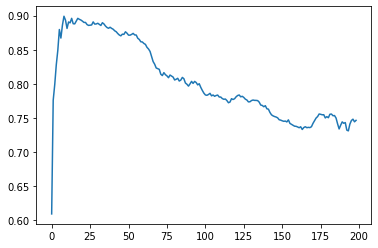

8


In [45]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

## Game Initialization

In [0]:
mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state = MinMaxScaler()
scaler_state.fit([detect(detect_range, x, accuracy_lookuptb) for x in x_range if np.prod(detect(detect_range, x, accuracy_lookuptb)) > 0])

scaler_reward = MinMaxScaler()
scaler_reward.fit([[x] for x in accuracy_list])

init_x = 190
detection = detect(detect_range, init_x, accuracy_lookuptb)
cur_nor_state = scaler_state.transform([detection])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state

In [26]:
np.array(cur_state).shape[0]

13

## Make a NN

In [0]:
def makeModel():
  fc1_dims = 200
  fc2_dims = 200
  model = Sequential([
      Dense(fc1_dims, input_shape=(np.array(cur_state).shape[0],)),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(len(step_options))
  ])


  model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='mse')

  return model

q_model = makeModel()

## Main

In [46]:
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_nor_his = []

n_games = 10
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

cur_x = init_x

rule_idle = True

idle_range = 0.0002
idle_steps = 5
reward_nor_buffer = []

action = 0
last_action = 0
momentum_counter = 0
count_momentum = True


for _ in tqdm(range(n_games)):
  cur_x = np.random.choice(x_range)
  for step_ctr in range(one_game_steps):
    
  # predict action
    
    if count_momentum:
      last_action = action

    if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized

      indices = np.random.choice(len(state_mem), batch_size, replace=False)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_nor_mem.values()))[indices]
      q_matrix = q_model.predict(batch_states)
      q_next = q_model.predict(batch_next_states)

      actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      batch_indices = np.arange(batch_size, dtype=np.int64)

      q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


      q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, len(cur_state))))]
    
    if action == 0:
      action = np.random.choice([1, -1])

    
    if count_momentum and last_action * action >0:
      momentum_counter += 1
    next_state, reward = step(cur_state, action, cur_x, accuracy_lookuptb)
    reward_nor = scaler_reward.transform([[reward]])[0][0]

    if rule_idle:
      try:
        reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
        if mem_ctr >= random_walk_period and max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
          break
      except:
        reward_nor_buffer.append(reward_nor)
    

    next_nor_state = scaler_state.transform([next_state])[0]
    next_x = max(min(cur_x + action, 200), 1)
    
    writeMem(cur_nor_state, next_nor_state, action, reward_nor)

    # print("cur_state = %s, cur_x = %s, action = %s, reward = %s"%(str(cur_state), str(cur_x), str(action), str(reward)))
    # print(reward_nor_buffer, max(reward_nor_buffer)- min(reward_nor_buffer))
    reward_nor_his.append(reward_nor)

    cur_state = next_state
    cur_nor_state = next_nor_state
    cur_x = next_x

    mem_ctr += 1

if count_momentum:
  print("Momentum = ", momentum_counter/mem_ctr)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

 20%|██        | 2/10 [00:06<00:19,  2.38s/it]

 30%|███       | 3/10 [00:12<00:23,  3.30s/it]

 40%|████      | 4/10 [00:17<00:24,  4.04s/it]

 50%|█████     | 5/10 [00:23<00:23,  4.64s/it]

 60%|██████    | 6/10 [00:29<00:20,  5.03s/it]

 70%|███████   | 7/10 [00:35<00:15,  5.25s/it]

 80%|████████  | 8/10 [00:41<00:10,  5.43s/it]

 90%|█████████ | 9/10 [00:46<00:05,  5.46s/it]

100%|██████████| 10/10 [00:52<00:00,  5.58s/it]



Momentum =  0.3396666666666667


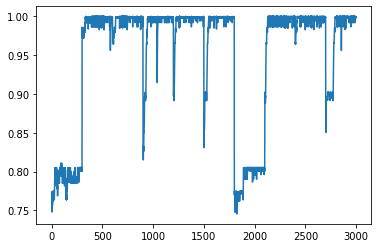

In [47]:
plt.plot([x for x in reward_nor_his if x > 0])

## Test the impact of state

In [0]:
cur_state_prediction = q_model.predict(cur_nor_state.reshape(1,5))[0]
cur_state_action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1,5))[0])]
print("Current x: ", cur_x)
print("Current state: ", cur_state)
print("Action at the current state: ", cur_state_action)

Current x:  92
Current state:  [0.7409111251036968, 0.7423174453898609, 0.7448774460277428, 0.7420021531874107, 0.7367552880181043]
Action at the current state:  -1


In [0]:
### reverse the accuracy at teh cur_state and normalize it
cur_nor_state_reverse = 1 - np.array(cur_nor_state)
print("After reverse the accuracy, the new action of the reversed state = ", step_options[np.argmax(q_model.predict([cur_nor_state_reverse.reshape(1, 5)])[0])])

After reverse the accuracy, the new action of the reversed state =  3


## Test by Changing Test Set

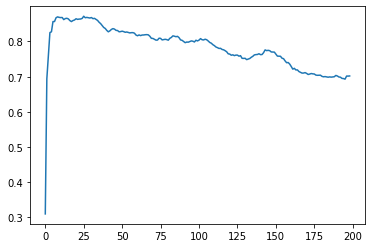

25


In [0]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  accuracy_list_test.append(calAccuracyTest(x))
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print(np.argmax(accuracy_list_test))

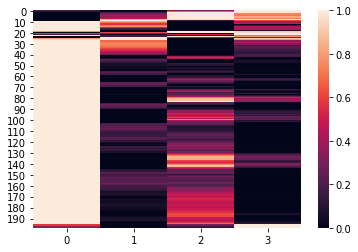

In [0]:
remove_0 = True

heat_map = np.array([])
for x in x_range:
  heat_map = np.append(heat_map, (q_model.predict(scaler_state.transform([detectTest(detect_range, x, accuracy_lookuptb_test)])[0].reshape(1, 5))[0]))
from seaborn import heatmap
heat_map = heat_map.reshape((len(heat_map)//5, 5))
if remove_0:
  heat_map = heat_map[:, [0, 1, 3, 4]]
heat_map = MinMaxScaler().fit_transform(heat_map.transpose()).transpose()
heatmap(heat_map)

In [12]:
cur_x = 140
next_x = -1
detection_test = detectTest(detect_range, x, accuracy_lookuptb_test)
cur_nor_state_test = scaler_state.transform([detection_test])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 5)))]
  next_x = cur_x + action_test
  next_state_test, reward_test = stepTest(cur_state_test, action_test, cur_x, accuracy_lookuptb_test)
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
  cur_x = next_x
  plt.scatter(cur_x, reward_test, alpha=step_ctr/ one_game_steps)


plt.plot(x_range, accuracy_list_test)
plt.show()

plt.plot(prediction_test)
print(cur_state_test)
print(max_state_test)

NameError: ignored



  0%|          | 0/10 [00:00<?, ?it/s]

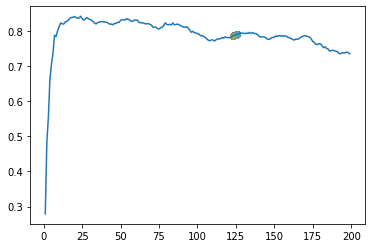



 10%|█         | 1/10 [00:14<02:09, 14.37s/it]

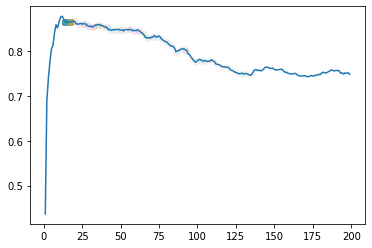



 20%|██        | 2/10 [00:28<01:54, 14.28s/it]

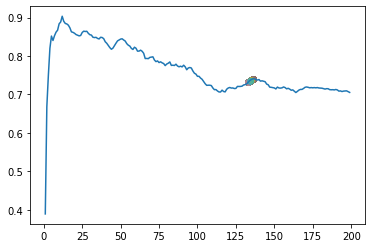



 30%|███       | 3/10 [00:42<01:39, 14.25s/it]

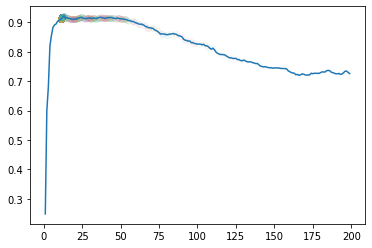



 40%|████      | 4/10 [00:56<01:25, 14.22s/it]

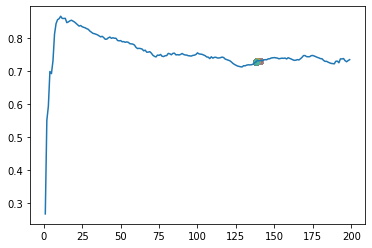



 50%|█████     | 5/10 [01:10<01:10, 14.19s/it]

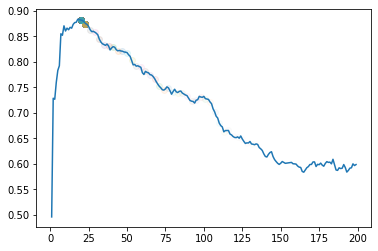



 60%|██████    | 6/10 [01:25<00:56, 14.19s/it]

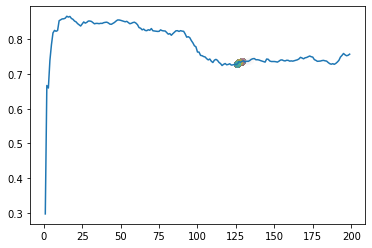



 70%|███████   | 7/10 [01:39<00:42, 14.17s/it]

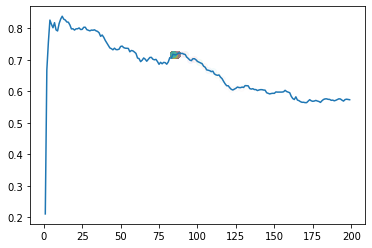



 80%|████████  | 8/10 [01:53<00:28, 14.21s/it]

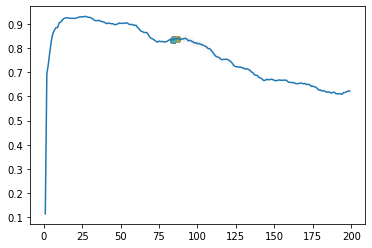



 90%|█████████ | 9/10 [02:07<00:14, 14.18s/it]

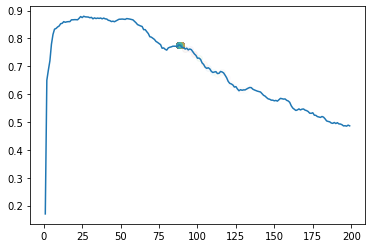



100%|██████████| 10/10 [02:21<00:00, 14.17s/it]



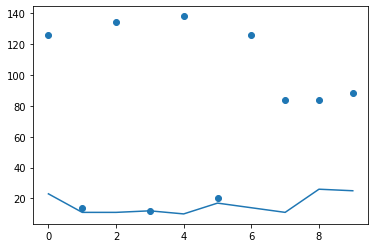

In [48]:
max_x_list = []
converge_x_list = []

n_tests = 10

for _ in tqdm(range(n_tests)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train_test = X[train_indices]
  X_test_test = X[test_indices]
  Y_train_test = Y[train_indices]
  Y_test_test = Y[test_indices]
  accuracy_list_test = []
  accuracy_lookuptb_test = {}
  for x in x_range:
    # accuracy_list_test.append(calAccuracyTest(x))
    accuracy_list_test.append(calAccuracyTest(x))
    accuracy_lookuptb_test[x] = accuracy_list_test[-1]
  max_x_list.append(np.argmax(accuracy_list_test))


  cur_x = 140
  next_x = -1
  detection_test = detectTest(detect_range, x, accuracy_lookuptb_test)
  cur_nor_state_test = scaler_state.transform([detection_test])[0]
  cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

  init_state_test = cur_state_test
  init_nor_state_test = cur_nor_state_test
  prediction_test = []
  cur_state_test = init_state_test
  max_state_test = cur_state_test
  for step_ctr in range(180):
    action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, len(cur_state))))]
    next_x = cur_x + action_test
    next_state_test, reward_test = stepTest(cur_state_test, action_test, cur_x, accuracy_lookuptb_test)
    if reward_test > max_state_test[3]:
      max_state_test = next_state_test
    next_nor_state_test = scaler_state.transform([next_state_test])[0]
    prediction_test.append(reward_test)
    cur_state_test = next_state_test
    cur_nor_state_test = next_nor_state_test
    cur_x = next_x
    plt.scatter(cur_x, reward_test, alpha=step_ctr/ one_game_steps)

  plt.plot(x_range, accuracy_list_test)
  plt.show()
  converge_x_list.append(cur_x)

plt.plot(range(n_tests), max_x_list)
plt.scatter(range(n_tests), converge_x_list)

0